In [2]:
from gurobipy import *
import xlwt
import xlrd
import pandas as pd
import numpy as np
from scipy.spatial import distance

In [3]:
# loading data
f = xlrd.open_workbook('data.xlsx')
sheet = f.sheet_by_index(0)

In [4]:
df1 = pd.read_excel('data.xlsx','FCs')
df2 = pd.read_excel('data.xlsx','DPs')

In [5]:
A = list(df1.iloc[0])
B = list(df2.iloc[0])
distance.euclidean(A,B)

69.462219947249025

In [10]:
# create a new model
myModel = Model("HW11_Q1")

# create decision vats and integrate them into the model
i_s = df1.shape[0] ## number of FC
j_s = df2.shape[0] ## number of DP
k_s = 3

# vars storage
c_s = [[0 for j in range(j_s)] for i in range(i_s)]
x_s = [[0 for k in range(k_s)] for i in range(i_s)]
y_s = [[[0 for k in range(k_s)] for j in range(j_s)] for i in range(i_s)]
n_s = [6,5,9]


# c_s (cij) for distances
for i in range(i_s):
    for j in range(j_s):
        a = list(df1.iloc[i])
        b = list(df2.iloc[j])
        c_s[i][j] = distance.euclidean(a,b)

# x_s (xik)
for i in range(i_s):
    for k in range(k_s):
        xVar = myModel.addVar(vtype=GRB.INTEGER, name='x' + str(i+1) + ',' + str(k+1))
        x_s[i][k] = xVar
        
myModel.update()

# y_s (yijk)
for i in range(i_s):
    for j in range(j_s):
        for k in range(k_s):
            yVar = myModel.addVar(vtype=GRB.INTEGER, name='y' + str(i+1) + ',' + str(j+1) + ',' + str(k+1))
            y_s[i][j][k] = yVar
        
myModel.update()

# create a linear expression for the objective
objExpr = LinExpr()
for i in range(i_s):
    for j in range(j_s):
        for k in range(k_s):
            yVar = y_s[i][j][k]
            c = c_s[i][j]
            n = n_s[k]
            objExpr += n*c*yVar
            myModel.setObjective(objExpr, GRB.MINIMIZE)
myModel.update()


# Constraint for number of FC in each stage
for k in range(k_s):
    constExpr = LinExpr()
    for i in range(i_s):
        xVar = x_s[i][k]
        constExpr += xVar
    myModel.addConstr(lhs=constExpr, sense=GRB.EQUAL, rhs=k+1, name="stage" + str(k+1))

# Constraint for empty FC locations
for k in range(k_s):
    for j in range(j_s):
        for i in range(i_s):
            constExpr = LinExpr()
            constExpr += x_s[i][k] - y_s[i][j][k]
            myModel.addConstr(lhs=constExpr, sense=GRB.GREATER_EQUAL, rhs=0, name="fc_location" + str(j+1))

# Constraint for fixed FC locations
for i in range(i_s):
    constExpr1 = LinExpr()
    constExpr1 += x_s[i][1] - x_s[i][0]
    constExpr2 = LinExpr()
    constExpr2 += x_s[i][2] - x_s[i][1]
    myModel.addConstr(lhs=constExpr1, sense=GRB.GREATER_EQUAL, rhs=0, name="fc_location_fix" + str(1) + str(i))
    myModel.addConstr(lhs=constExpr2, sense=GRB.GREATER_EQUAL, rhs=0, name="fc_location_fix" + str(2) + str(i))
            
# Constraint for each DP has exactly 1 FC
for k in range(k_s):
    for j in range(j_s):
        constExpr = LinExpr()
        for i in range(i_s):
            yVar = y_s[i][j][k]
            constExpr += yVar
        myModel.addConstr(lhs=constExpr, sense=GRB.EQUAL, rhs=1, name="full_cover" + str(j+1) + ',' + str(k+1))

# boundaries
for k in range(k_s):
    for j in range(j_s):
        for i in range(i_s):
            constExpr = LinExpr()
            constExpr = y_s[i][j][k]
            myModel.addConstr(lhs=constExpr, sense=GRB.LESS_EQUAL, rhs=1, name="boundary_y" + str(i+1) + ',' + str(j+1) + ',' + str(k+1))   

for k in range(k_s):
    for i in range(i_s):
        constExpr = LinExpr()
        constExpr = x_s[i][k]
        myModel.addConstr(lhs=constExpr, sense=GRB.LESS_EQUAL, rhs=1, name="boundary_x" + str(i+1) + ',' + str(k+1))   

            
# integrate objective and constraints into the model
myModel.update()

# write the model in a file to make sure it is constructed correctly
myModel.write(filename="HW11_Q1.lp")

# optimize the model
myModel.optimize()

# save result to xls file
allVars = myModel.getVars()

# writebook = xlwt.Workbook()
# sheet1 = writebook.add_sheet('test')

# for i in range(71):
#     for j in range(21):
#         if(allVars[21*i+j].x == 1):
#             sheet1.write(i+1,j+1,sheet.cell(i+1,j+1).value)

# writebook.save('result.xls')


Optimize a model with 1313 rows, 630 columns and 2500 nonzeros
Variable types: 0 continuous, 630 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 850 rows and 200 columns
Presolve time: 0.02s
Presolved: 463 rows, 430 columns, 1270 nonzeros
Variable types: 0 continuous, 430 integer (430 binary)
Found heuristic solution: objective 15045.911688

Root relaxation: objective 1.276015e+04, 216 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    12760.151023 12760.1510  0.00%     -    0s

Explored 0 nodes (216 simplex iterations) in 0.09 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 12760.2 15045.9 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.2760151

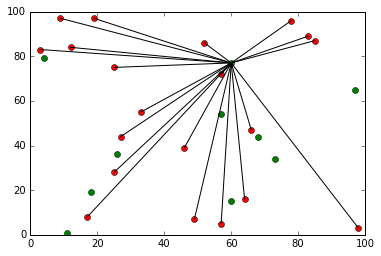

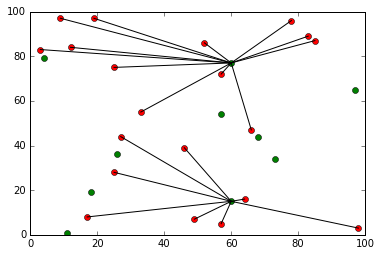

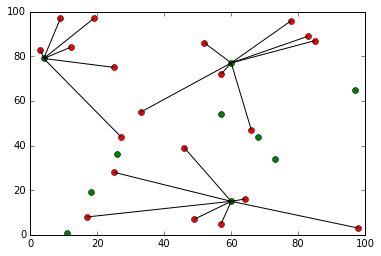

In [11]:
import matplotlib.pyplot

# this array includes the coordinates of fulfillment centers
# there are 10 fulfillment center locations
# for each fulfillment center, we keep x and y coordinates
nofcs = 10
fcs = [ 0 for j in range ( nofcs ) ]
fcs[0] = [60 , 15]
fcs[1] = [26 , 36]
fcs[2] = [73 , 34]
fcs[3] = [57 , 54]
fcs[4] = [18 , 19]
fcs[5] = [11 , 1]
fcs[6] = [60 , 77]
fcs[7] = [68 , 44]
fcs[8] = [97 , 65]
fcs[9] = [4 , 79]

# this array includes the coordinates of demand points
# there are 10 demand points
# for each demand point, we keep x and y coordinates
# for this example, there are 20 demand points
nodps = 20
dps = [ 0 for j in range ( nodps ) ]
dps[0] = [25 , 75]
dps[1] = [49 , 7]
dps[2] = [17 , 8]
dps[3] = [12 , 84]
dps[4] = [3 , 83]
dps[5] = [57 , 5]
dps[6] = [46 , 39]
dps[7] = [83 , 89]
dps[8] = [78 , 96]
dps[9] = [27 , 44]
dps[10] = [64 , 16]
dps[11] = [52 , 86]
dps[12] = [57 , 72]
dps[13] = [33 , 55]
dps[14] = [66 , 47]
dps[15] = [25 , 28]
dps[16] = [9 , 97]
dps[17] = [85 , 87]
dps[18] = [98 , 3]
dps[19] = [19 , 97]

# this array includes which fulfillment center each demand point is connected to
for k in range(k_s):
    assgns = [ 0 for j in range ( nodps ) ]
    for j in range(j_s):
        for i in range(i_s):
            if int(y_s[i][j][k].x) == 1:
                assgns[j] = i

    for fc in range( nofcs ):
        matplotlib.pyplot.plot( fcs[ fc ][ 0 ]  , fcs[ fc ][ 1 ] , 'ro' , color = "green" , lw = 9 )

    for dp in range( nodps ):
        matplotlib.pyplot.plot( dps[ dp ][ 0 ]  , dps[ dp ][ 1 ] , 'ro' , color = "red" , lw = 9 )

    for dp in range( nodps ):
        dpx = dps[ dp ][ 0 ]
        dpy = dps[ dp ][ 1 ]
        fcx = fcs[ assgns[ dp ] ][ 0 ]
        fcy = fcs[ assgns[ dp ] ][ 1 ]
        matplotlib.pyplot.plot( [ dpx , fcx ], [ dpy , fcy ]  , color = "black"  )

    matplotlib.pyplot.show()

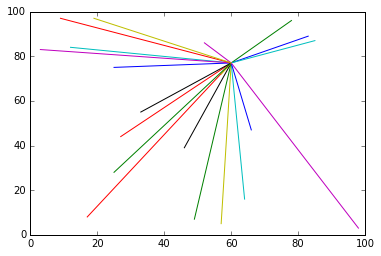

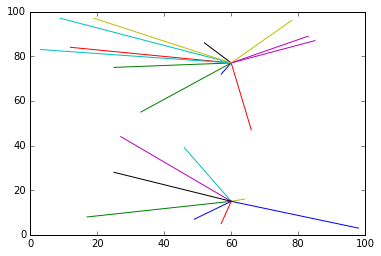

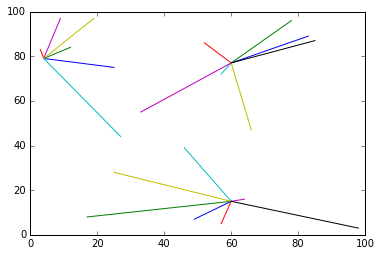

In [8]:
import matplotlib.pyplot as plt
plt.figure()
for i in range(i_s):
    for j in range(j_s):
        if(int(x_s[i][0].x)==1 and int(y_s[i][j][0].x)==1):
            x = [df1.iloc[i][0],df2.iloc[j][0]]
            y = [df1.iloc[i][1],df2.iloc[j][1]]
            plt.plot(x,y)
plt.show()
for i in range(i_s):
    for j in range(j_s):
        if(int(x_s[i][1].x)==1 and int(y_s[i][j][1].x)==1):
            x = [df1.iloc[i][0],df2.iloc[j][0]]
            y = [df1.iloc[i][1],df2.iloc[j][1]]
            plt.plot(x,y)
plt.show()
for i in range(i_s):
    for j in range(j_s):
        if(int(x_s[i][2].x)==1 and int(y_s[i][j][2].x)==1):
            x = [df1.iloc[i][0],df2.iloc[j][0]]
            y = [df1.iloc[i][1],df2.iloc[j][1]]
            plt.plot(x,y)
plt.show()